In [15]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%autoreload 2

In [17]:
import tensorflow as tf

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

## Parameters

In [19]:
NSAMPLE = 2500

In [20]:
from aml_dl.mdn.training.config import network_params_inv

In [21]:
from aml_dl.mdn.model.mdn_push_inv_model import MDNPushInverseModel

In [22]:
from aml_data_collec_utils.core.data_manager import DataManager

/home/ermanoarruda/Projects/aml_data/aml_dl/baxter_push_data/


In [23]:
sess = tf.InteractiveSession()

In [24]:
inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)
inverse_model.init_model()

In [25]:
x_curr   = np.random.randn(1,7).tolist()[0]
x_tgt    = np.random.randn(1,7).tolist()[0]
u_action = np.random.random((1,2))

In [26]:
input_x = np.expand_dims(np.r_[x_curr, x_tgt], 0)
mus = inverse_model.run_op('mu', input_x)[0]
sigma = inverse_model.run_op('sigma', input_x)[0]
pis = inverse_model.run_op('pi', input_x)[0]
loss = inverse_model._mdn.run_op(sess,'loss', xs = input_x, ys = u_action)[0]

print "MUS: ", mus
print "SIGMA: ", sigma
print "PIs:", pis
print "LOSS:", loss
#theta = inverse_model.sample_out_max_pi(input_x, 1)[0]
    
pi_idx = inverse_model._max_pi_idx(pis)

action = mus[:,pi_idx]


MUS:  [[-0.06632147 -0.01980226  0.23443078  0.06394701  0.10637057  0.31608039
  -0.43730515 -0.02726905 -0.11748452  0.04545816 -0.00369244  0.08010677
   0.20552026 -0.02364001  0.22460225 -0.10713188 -0.29869932 -0.15187237
   0.20880371 -0.36825228  0.01997926 -0.04595007 -0.03448287 -0.35756007]
 [ 0.01306449 -0.05134765  0.22593008 -0.03616702  0.15934646  0.19343002
   0.21389174 -0.01169563 -0.02053431 -0.0410552  -0.19987559  0.1734753
   0.15441699 -0.22108024  0.05489164  0.39590311 -0.07286464 -0.21093205
   0.05039793  0.20887946 -0.19845808 -0.32748869 -0.29337537  0.16070622]]
SIGMA:  [ 0.87090135  0.99707037  1.33323097  1.13822842  0.58309168  1.19196594
  1.15463972  0.90769523  0.78909433  0.96342349  0.78496677  0.98520315
  1.0739522   0.89752275  0.89338183  0.91518813  0.89104623  1.0544678
  1.01789796  1.11135995  1.12982774  1.29846907  0.79848963  0.99217588]
PIs: [ 0.04746579  0.03889333  0.05075901  0.04411351  0.03928443  0.04575402
  0.05355414  0.035237

In [27]:
network_params_inv['dim_input'] = 14
network_params_inv['dim_output'] = 2
network_params_inv['k_mixtures'] = 24

inverse_model = MDNPushInverseModel(sess=sess, network_params=network_params_inv)
inverse_model.init_model()

In [31]:
data_file_indices = network_params_inv['train_file_indices']

data_man = DataManager(data_folder_path=network_params_inv['training_data_path'], data_name_prefix='test_push_data')

In [33]:
ids=range(0,5)
x_keys = ['box_pos', 'box_ori', 'task_action']
y_keys = ['box_pos', 'box_ori']
x_sub_keys = [[None],[None],['push_xz']]
y_sub_keys = [[None],[None]]

data_x, data_y = data_man.pack_data_in_range_xy(x_keys=x_keys, y_keys=y_keys, 
                                                 x_sub_keys=x_sub_keys, y_sub_keys=y_sub_keys, 
                                                 ids=ids, 
                                                 before_after=True, 
                                                 data_file_range=data_file_indices)

In [30]:
data_y

[]

In [13]:
xs = np.random.uniform(-10.5, 10.5, (14, NSAMPLE)).T
ys = np.random.uniform(-10.5, 10.5, (2, NSAMPLE)).T

In [14]:
sess.run(tf.global_variables_initializer())

NEPOCH = 10000
loss = inverse_model.train(x_data = xs, y_data = ys, epochs =  NEPOCH)

In [15]:
print loss

[ 11.97430515  11.87326908  11.7735281  ...,   4.26669216   4.26635313
   4.26635647]


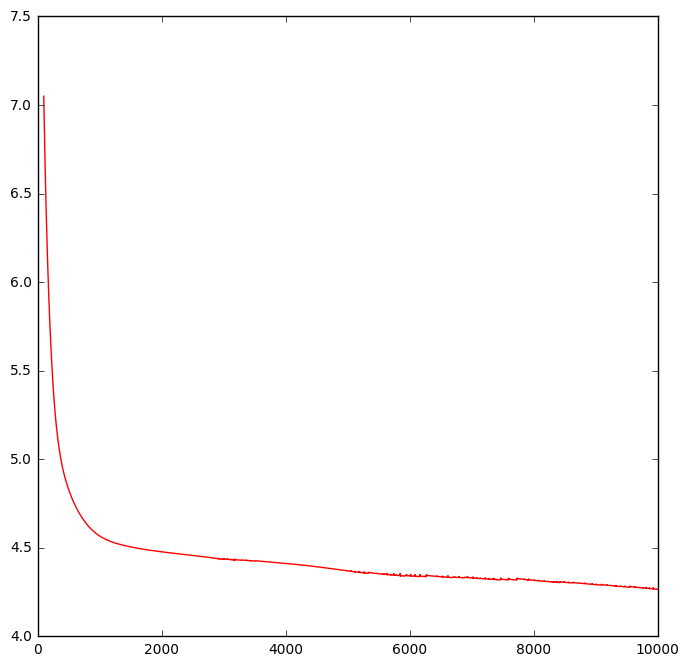

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, NEPOCH,1), loss[100:], 'r-')
plt.show()

In [17]:
from aml_dl.mdn.model.tf_mdn_model import MixtureOfGaussians

In [18]:
out_pi = inverse_model._net_ops['pi']
out_sigma = inverse_model._net_ops['sigma']
out_mu = inverse_model._net_ops['mu']
x = inverse_model._net_ops['x']

In [19]:
mixture = MixtureOfGaussians()

In [20]:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector


In [21]:
out_pi_test, out_sigma_test, out_mu_test = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_test})

ValueError: Cannot feed value of shape (300, 1) for Tensor u'x_1:0', which has shape '(?, 14)'

In [ ]:
# print out_mu_test.reshape((300,2))

In [ ]:
out_mu_test = out_mu_test.reshape((300,24))
print out_pi_test.shape, x_test.shape, out_sigma_test.shape, out_mu_test.shape


In [ ]:


y_test = mixture.generate_mixture_samples(out_pi_test, out_mu_test, out_sigma_test,100)

plt.figure(figsize=(8, 8))
plt.plot(x_data,y_data,'ro', x_test,y_test,'bo',alpha=0.3)
plt.show()